In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("test_pyspark") \
    .config("spark.driver.memory", "100g") \
    .config("spark.executor.memory", "100g") \
    .config("spark.sql.orc.enableVectorizedReader", "false") \
    .config("spark.sql.parquet.columnarReaderBatchSize", "256") \
    .config("spark.sql.orc.columnarReaderBatchSize", "256") \
    .config("spark.sql.shuffle.partitions", "1024") \
    .config("spark.driver.maxResultSize", "4g") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/10 09:48:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
import dotenv

dotenv.load_dotenv()

True

# Download Works Denormalised from ElasticSearch

In [30]:
import os
from elasticsearch import Elasticsearch
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, ArrayType, BooleanType

# Get Elasticsearch connection details from environment
es_cloud_id = os.getenv('ES_CLOUD_ID_WORKS_DENORMALISED')
es_api_key = os.getenv('ES_API_KEY_WORKS_DENORMALISED')
# es_username = os.getenv('ES_USERNAME', 'elastic')
# es_password = os.getenv('ES_PASSWORD')

# print(f"ES_CLOUD_ID_WORKS_DENORMALISED: {es_cloud_id}")
# print(f"ES_API_KEY_WORKS_DENORMALISED: {es_api_key}")
# if not es_cloud_id or not es_password:
#     raise ValueError("ES_CLOUD_ID_WORKS_DENORMALISED and ES_PASSWORD environment variables must be set")

# Initialize Elasticsearch client
es = Elasticsearch(
    cloud_id=es_cloud_id,
    # "https://pipeline-2025-05-01.es.eu-west-1.aws.found.io",
    api_key=es_api_key
)


# Index name
index_name = "works-denormalised-2025-05-01"



In [31]:
# Explore the data field of the visible work document
try:
    response = es.search(
        index=index_name,
        body={
            "query": {
                "bool": {
                    "must_not": [
                        {"term": {"type": "Redirected"}},
                        {"term": {"type": "Deleted"}}
                    ]
                }
            },
            "size": 1
        }
    )
    
    if response['hits']['hits']:
        hit = response['hits']['hits'][0]
        doc = hit['_source']
        
        print(f"Document ID: {hit['_id']}")
        print(f"Document Type: {doc.get('type', 'Unknown')}")
        
        if 'data' in doc:
            data = doc['data']
            print(f"\n--- Data Field Contents ---")
            print(f"Data field has {len(data)} keys:")
            
            for key, value in data.items():
                if isinstance(value, dict):
                    print(f"  {key}: dict with {len(value)} keys")
                elif isinstance(value, list):
                    print(f"  {key}: list with {len(value)} items")
                elif isinstance(value, str):
                    # Truncate long strings
                    display_value = value[:100] + "..." if len(value) > 100 else value
                    print(f"  {key}: '{display_value}'")
                else:
                    print(f"  {key}: {value}")
            
            # Show specific work information
            print(f"\n--- Work Details ---")
            if 'id' in data:
                print(f"Work ID: {data['id']}")
            if 'title' in data:
                print(f"Title: {data['title']}")
            if 'workType' in data:
                print(f"Work Type: {data['workType']}")
            if 'createdDate' in data:
                print(f"Created Date: {data['createdDate']}")
            if 'description' in data:
                desc = str(data['description'])[:300] + "..." if len(str(data['description'])) > 300 else data['description']
                print(f"Description: {desc}")
                
            # Check items
            if 'items' in data:
                print(f"\nItems: {len(data['items'])} items")
                if data['items']:
                    first_item = data['items'][0]
                    print(f"  First item ID: {first_item.get('id', 'N/A')}")
                    print(f"  First item keys: {list(first_item.keys())}")
                    
            # Check subjects
            if 'subjects' in data:
                print(f"\nSubjects: {len(data['subjects'])} subjects")
                if data['subjects']:
                    first_subject = data['subjects'][0]
                    print(f"  First subject: {first_subject}")
                    
        else:
            print("No 'data' field found in document")
            
except Exception as e:
    print(f"Error: {e}")

Document ID: z8v29xvn
Document Type: Visible

--- Data Field Contents ---
Data field has 17 keys:
  title: 'Rationales for therapy in British psychiatry, 1780-1835 / William F. Bynum, Jr.'
  otherIdentifiers: list with 1 items
  alternativeTitles: list with 0 items
  format: dict with 2 keys
  physicalDescription: 'pages 35-57'
  subjects: list with 0 items
  genres: list with 1 items
  contributors: list with 1 items
  production: list with 0 items
  languages: list with 1 items
  notes: list with 2 items
  items: list with 2 items
  holdings: list with 0 items
  imageData: list with 0 items
  workType: 'Standard'
  formerFrequency: list with 0 items
  designation: list with 0 items

--- Work Details ---
Title: Rationales for therapy in British psychiatry, 1780-1835 / William F. Bynum, Jr.
Work Type: Standard

Items: 2 items
  First item ID: {'canonicalId': 'u8x7xjge', 'sourceIdentifier': {'identifierType': {'id': 'sierra-system-number'}, 'ontologyType': 'Item', 'value': 'i12771144'},

In [32]:
import json
import os
from datetime import datetime
from tqdm import tqdm

# Create output directory
output_dir = "/home/ubuntu/wc_simd/data/tmp/es_works_denormalised_exports"
os.makedirs(output_dir, exist_ok=True)

# Page through all entries and save to JSON files
def save_entries_to_json():
    scroll_size = 100  # Number of documents per batch
    scroll_time = '10m'  # How long to keep scroll context alive
    
    # Initialize scroll search
    print(f"Starting to export all entries from index: {index_name}")
    print(f"Output directory: {output_dir}")
    print(f"Scroll size: {scroll_size}")
    
    try:
        # Initial search request
        response = es.search(
            index=index_name,
            body={
                "query": {
                    "bool": {
                        "must_not": [
                            {"term": {"type": "Redirected"}},
                            {"term": {"type": "Deleted"}}
                        ]
                    }
                },
            },
            size=scroll_size,
            scroll=scroll_time
        )
        
        scroll_id = response['_scroll_id']
        total_hits = response['hits']['total']['value']
        
        print(f"Total documents to process: {total_hits}")
        
        processed_count = 0
        saved_count = 0
        skipped_count = 0
        errors_count = 0
        
        # Create progress bar
        pbar = tqdm(total=total_hits, desc="Processing documents", unit="docs")
        
        # Process first batch
        while True:
            hits = response['hits']['hits']
            
            if not hits:
                break
                
            for hit in hits:
                try:
                    doc = hit['_source']
                    doc_id = hit['_id']
                    
                    # Try to get canonicalId from different possible locations
                    canonical_id = None
                    
                    # Check if it's a visible work with data field
                    if 'data' in doc and 'id' in doc['data']:
                        canonical_id = doc['data']['id']
                    # Check if it's a redirected work
                    elif 'redirectTarget' in doc and 'id' in doc['redirectTarget']:
                        canonical_id = doc['redirectTarget']['id']
                    # Check if there's a direct id field
                    elif 'id' in doc:
                        canonical_id = doc['id']
                    # Use the Elasticsearch document ID as fallback
                    else:
                        canonical_id = doc_id
                        
                    # Clean the canonical_id to be filesystem-safe
                    safe_id = canonical_id.replace('/', '_').replace('\\', '_').replace(':', '_')
                    
                    # Create filename
                    filename = f"{safe_id}.json"
                    filepath = os.path.join(output_dir, filename)
                    
                    # Skip if file already exists
                    if os.path.exists(filepath):
                        skipped_count += 1
                        processed_count += 1
                        pbar.update(1)
                        pbar.set_postfix({
                            'saved': saved_count,
                            'skipped': skipped_count,
                            'errors': errors_count
                        })
                        continue
                    
                    # Add metadata to the document
                    doc_with_metadata = {
                        'elasticsearch_id': doc_id,
                        'canonical_id': canonical_id,
                        'exported_at': datetime.now().isoformat(),
                        'document': doc
                    }
                    
                    # Save to JSON file
                    with open(filepath, 'w', encoding='utf-8') as f:
                        json.dump(doc_with_metadata, f, indent=2, ensure_ascii=False)
                    
                    saved_count += 1
                    processed_count += 1
                    
                    # Update progress bar
                    pbar.update(1)
                    pbar.set_postfix({
                        'saved': saved_count,
                        'skipped': skipped_count,
                        'errors': errors_count
                    })
                        
                except Exception as e:
                    pbar.write(f"Error processing document {doc_id}: {e}")
                    errors_count += 1
                    processed_count += 1
                    pbar.update(1)
                    pbar.set_postfix({
                        'saved': saved_count,
                        'skipped': skipped_count,
                        'errors': errors_count
                    })
                    
            # Get next batch
            try:
                response = es.scroll(scroll_id=scroll_id, scroll=scroll_time)
            except Exception as e:
                pbar.write(f"Error getting next batch: {e}")
                break
                
        # Close progress bar
        pbar.close()
        
        # Clean up scroll context
        try:
            es.clear_scroll(scroll_id=scroll_id)
        except Exception as e:
            print(f"Error clearing scroll: {e}")
            
        print(f"\nExport completed!")
        print(f"Total processed: {processed_count}")
        print(f"Successfully saved: {saved_count}")
        print(f"Skipped (already exists): {skipped_count}")
        print(f"Errors: {errors_count}")
        print(f"Files saved to: {output_dir}")
        
    except Exception as e:
        print(f"Error during export: {e}")
        
# Run the export
save_entries_to_json()

Starting to export all entries from index: works-denormalised-2025-05-01
Output directory: /home/ubuntu/wc_simd/data/tmp/es_works_denormalised_exports
Scroll size: 100


/tmp/ipykernel_5387/80118970.py:22: DeprecationWarning: Received 'size' via a specific parameter in the presence of a 'body' parameter, which is deprecated and will be removed in a future version. Instead, use only 'body' or only specific parameters.
  response = es.search(


Total documents to process: 1173961


Processing documents: 100%|██████████| 1173961/1173961 [1:00:42<00:00, 322.30docs/s, saved=1173961, skipped=0, errors=0]



Export completed!
Total processed: 1173961
Successfully saved: 1173961
Skipped (already exists): 0
Errors: 0
Files saved to: /home/ubuntu/wc_simd/data/tmp/es_works_denormalised_exports


In [4]:
import glob
import random
from wc_simd.utility import spark_path
# 1) find all paths, sample N of them
all_paths = glob.glob(
    "/home/ubuntu/wc_simd/data/tmp/es_works_denormalised_exports/*.json")
sample_paths = [spark_path(path) for path in random.sample(all_paths, 100000)]

In [8]:
all_paths = [spark_path(path) for path in all_paths]

In [13]:
len(all_paths)

1173961

# Sample downloaded JSON

In [ ]:
import glob
import random

all_paths = glob.glob(
    "/home/ubuntu/wc_simd/data/tmp/es_works_denormalised_exports/*.json")

In [ ]:
# random select a path and print it
random_path = random.choice(all_paths)
print(f"Randomly selected path: {random_path}")
# print json
with open(random_path, 'r', encoding='utf-8') as f:
    json_data = json.load(f)
    print(json.dumps(json_data, indent=2, ensure_ascii=False))
    

Randomly selected path: /home/ubuntu/wc_simd/data/tmp/es_works_denormalised_exports/u8cxwakb.json
{
  "elasticsearch_id": "u8cxwakb",
  "canonical_id": "u8cxwakb",
  "exported_at": "2025-07-07T15:56:37.557130",
  "document": {
    "version": 20250611,
    "data": {
      "title": "A defence of the establish'd church and laws, in answer to a book entitul'd, A vindication of marriage, as solemniz'd by Presbyterians in the north of Ireland",
      "otherIdentifiers": [],
      "alternativeTitles": [
        "Defence of the establish'd church and laws, in answer to a book entitul'd, A vindication of marriage, as solemniz'd by Presbyterians in the north of Ireland (Online)"
      ],
      "format": {
        "id": "v",
        "label": "E-books"
      },
      "subjects": [],
      "genres": [],
      "contributors": [
        {
          "id": {
            "type": "Unidentifiable"
          },
          "agent": {
            "id": {
              "canonicalId": "us4wda2s",
              

# Create Works Denormalised Spark Table

In [ ]:
import json
import glob
import os
from tqdm import tqdm

input_dir = "../data/tmp/es_works_denormalised_exports"
pattern = os.path.join(input_dir, "*.json")
out_path = os.path.join("../data/tmp", "es_works_denormalised.json")

# First count the total number of files to process
total_files = len(list(glob.iglob(pattern)))
print(f"Combining {total_files} JSON files into {out_path}")

with open(out_path, "w") as fout:
    fout.write("[")
    first = True
    # count = 0
    # Use tqdm to display progress
    for path in tqdm(glob.iglob(pattern), total=total_files, desc="Combining files", unit="file"):
        try:
            with open(path, "r") as fin:
                data = json.load(fin)
        except Exception as e:
            # Log error and skip malformed files
            print(f"Error reading {path}: {e}")
            continue

        if not first:
            fout.write(",\n")
        else:
            first = False

        json.dump(data, fout)
        # count += 1
        # if count > 1000:
        #     break

    fout.write("]")

print(f"Combined JSON file saved to {out_path}")

Combining 1173961 JSON files into ../data/es_works_denormalised.json


Combining files: 100%|██████████| 1173961/1173961 [34:48<00:00, 562.09file/s] 


Combined JSON file saved to ../data/es_works_denormalised.json


In [25]:
# Create Spark DataFrame from all JSON files with auto schema inference
from pyspark.sql import functions as F
from wc_simd.utility import spark_path

# Read all JSON files and let Spark infer the schema across all files
# This will examine all files to build a comprehensive schema
df = spark.read \
    .option("multiline", "true") \
    .option("inferSchema", "true") \
    .json(spark_path("../data/es_works_denormalised.json"))


df

DataFrame[canonical_id: string, document: struct<data:struct<alternativeTitles:array<string>,collectionPath:struct<label:string,path:string>,contributors:array<struct<agent:struct<id:struct<canonicalId:string,otherIdentifiers:array<string>,sourceIdentifier:struct<identifierType:struct<id:string>,ontologyType:string,value:string>,type:string>,label:string,type:string>,id:struct<type:string>,primary:boolean,roles:array<struct<label:string>>>>,createdDate:struct<id:struct<type:string>,label:string,range:struct<from:string,label:string,to:string>>,currentFrequency:string,description:string,designation:array<string>,duration:bigint,edition:string,format:struct<id:string,label:string>,formerFrequency:array<string>,genres:array<struct<concepts:array<struct<id:struct<canonicalId:string,otherIdentifiers:array<string>,sourceIdentifier:struct<identifierType:struct<id:string>,ontologyType:string,value:string>,type:string>,label:string,range:struct<from:string,label:string,to:string>,type:string>>,

In [26]:
df.write.saveAsTable("es_works_denormalised", mode="overwrite")
    

In [27]:
spark.table("es_works_denormalised").count()

1173961

In [28]:
spark.table("es_works_denormalised").select("*").show(5, truncate=True)

+------------+--------------------+----------------+--------------------+
|canonical_id|            document|elasticsearch_id|         exported_at|
+------------+--------------------+----------------+--------------------+
|    tb392c95|{{[], {WT/A/4/4/2...|        tb392c95|2025-07-07T16:07:...|
|    vcscpyzp|{{[Drug discovery...|        vcscpyzp|2025-07-07T15:46:...|
|    udtgc4ru|{{[], NULL, [{{{e...|        udtgc4ru|2025-07-07T15:30:...|
|    tpguvd2r|{{[], NULL, [], N...|        tpguvd2r|2025-07-07T15:30:...|
|    yp93hb28|{{[], NULL, [{{{x...|        yp93hb28|2025-07-07T15:35:...|
+------------+--------------------+----------------+--------------------+
only showing top 5 rows



In [ ]:
# Select document fields without the top-level "document" field
spark.table("es_works_denormalised").select("document.data.*").show(5, truncate=True)

+--------------------+--------------------+--------------------+-----------+------------------+--------------------+--------------------+--------+-------+--------------------+---------------+--------------------+--------------------+--------------------+--------------------+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+--------------------+--------------------+--------+
|   alternativeTitles|      collectionPath|        contributors|createdDate|  currentFrequency|         description|         designation|duration|edition|              format|formerFrequency|              genres|            holdings|           imageData|               items|       languages|           lettering|               notes|    otherIdentifiers| physicalDescription|          production|referenceNumber|            subjects|           thumbnail|               title|workType|
+--------------------+------

## Genres

In [15]:
from pyspark.sql import functions as F

# Select document fields without the top-level "document" field
genres_df = (
    spark.table("es_works_denormalised").select(F.explode("document.data.genres")).select("col.*")
    .select(F.explode("concepts")).select("col.*")
    .select("label", "type", "id.*")
    # .select("*", "sourceIdentifier.*").drop("sourceIdentifier")
    # .select("*", F.col("identifierType.id").alias("identifierTypeId")).drop("identifierType")
    # .drop("otherIdentifiers")
)

genres_df.show(5, truncate=True)
print("Distinct count", genres_df.distinct().count())
print("Distinct count without CanonicalId",
      genres_df.dropDuplicates(["label", "type"]).count())

+-------------------+------------+-----------+----------------+--------------------+----------+
|              label|        type|canonicalId|otherIdentifiers|    sourceIdentifier|      type|
+-------------------+------------+-----------+----------------+--------------------+----------+
|Electronic journals|GenreConcept|   b58xjqdv|              []|{{label-derived},...|Identified|
|         Periodical|GenreConcept|   w3mu5a5f|              []|{{label-derived},...|Identified|
|           Fulltext|GenreConcept|   cdb8asy2|              []|{{label-derived},...|Identified|
| Internet Resources|GenreConcept|   w5vnzng3|              []|{{label-derived},...|Identified|
|        Periodicals|GenreConcept|   g6tt55sn|              []|{{label-derived},...|Identified|
+-------------------+------------+-----------+----------------+--------------------+----------+
only showing top 5 rows

Distinct count 1427
Distinct count without CanonicalId 1410


In [23]:
from pyspark.sql import functions as F

# Select document fields without the top-level "document" field
genres_df = (
    spark.table("es_works_denormalised").select(F.explode("document.data.genres")).select("col.*")
    .select(F.explode("concepts")).select("col.*")
    .select("label", "type", F.col("id.canonicalId").alias("idCanonicalId"), F.col("id.otherIdentifiers").alias("idOtherIdentifiers"), F.col("id.sourceIdentifier").alias("idSourceIdentifier"), F.col("id.type").alias("idType"))
    # .select("idSourceIdentifier.*")
    .select("*", F.col("idSourceIdentifier.identifierType").alias("sourceIdentifierIdentifierType"), F.col("idSourceIdentifier.ontologyType").alias("sourceIdentifierOntologyType"), F.col("idSourceIdentifier.value").alias("sourceIdentifierValue")).drop("idSourceIdentifier")
    .select("*", F.col("sourceIdentifierIdentifierType.id").alias("sourceIdentifierTypeId")).drop("sourceIdentifierIdentifierType")
    # .drop("otherIdentifiers")
)

genres_df.show(100, truncate=True)
print("Distinct count", genres_df.distinct().count())
print("Distinct count without CanonicalId",
      genres_df.dropDuplicates(["label", "type"]).count())

+--------------------+------------+-------------+------------------+----------+----------------------------+---------------------+----------------------+
|               label|        type|idCanonicalId|idOtherIdentifiers|    idType|sourceIdentifierOntologyType|sourceIdentifierValue|sourceIdentifierTypeId|
+--------------------+------------+-------------+------------------+----------+----------------------------+---------------------+----------------------+
| Electronic journals|GenreConcept|     b58xjqdv|                []|Identified|                       Genre|  electronic journals|         label-derived|
|          Periodical|GenreConcept|     w3mu5a5f|                []|Identified|                       Genre|           periodical|         label-derived|
|            Fulltext|GenreConcept|     cdb8asy2|                []|Identified|                       Genre|             fulltext|         label-derived|
|  Internet Resources|GenreConcept|     w5vnzng3|                []|Identifi

Distinct count 1427
Distinct count without CanonicalId 1410


### sourceIdentifierTypeId

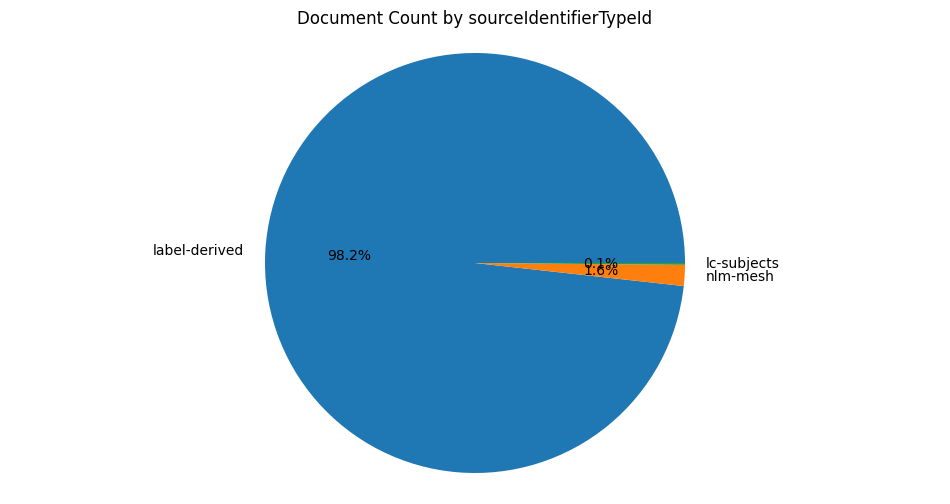

,count
sourceIdentifierTypeId,
label-derived,1402
nlm-mesh,23
lc-subjects,2


In [25]:
plot_df = genres_df.distinct().groupBy("sourceIdentifierTypeId").count( ).orderBy(
    "count", ascending=False).toPandas().set_index("sourceIdentifierTypeId")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.pie(plot_df["count"], labels=plot_df.index, autopct='%1.1f%%')
plt.title("Document Count by sourceIdentifierTypeId")
plt.axis('equal')
plt.show()

plot_df

### type

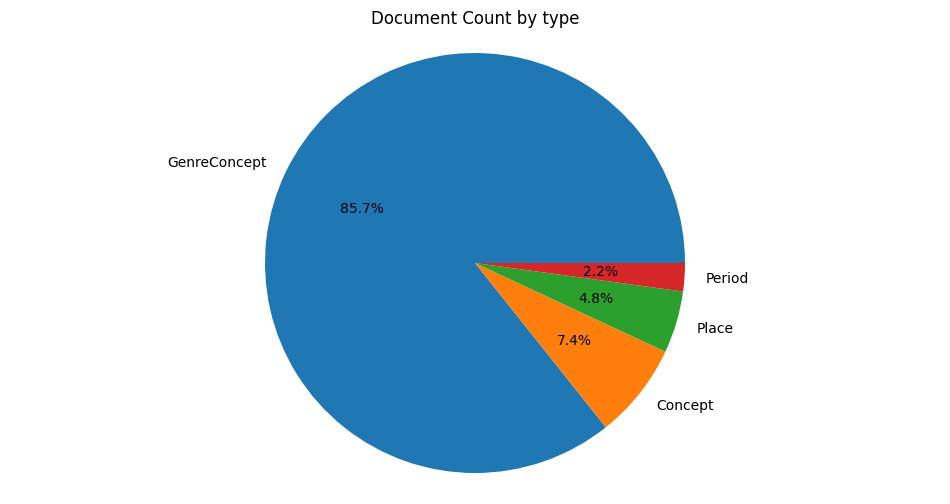

,count
type,
GenreConcept,1223
Concept,105
Place,68
Period,31


In [26]:
plot_df = genres_df.distinct().groupBy("type").count().orderBy(
    "count", ascending=False).toPandas().set_index("type")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.pie(plot_df["count"], labels=plot_df.index, autopct='%1.1f%%')
plt.title("Document Count by type")
plt.axis('equal')
plt.show()

plot_df

## Subjects

In [44]:
from pyspark.sql import functions as F

# Select document fields without the top-level "document" field
subjects_df = (
    spark.table("es_works_denormalised")
    .select("document.data.*")
    .select(F.explode("subjects")).select("col.*")
    .select("*",
         "id.*"
         ).drop("id")
    .select("*", "sourceIdentifier.*", F.col("identifierType.id").alias("identifierTypeId")).drop("sourceIdentifier", "identifierType", "otherIdentifiers")
    .select("*", F.explode("concepts"))
    .select(
        "*",
        F.col("col.id").alias("conceptId"),
        F.col("col.label").alias("conceptLabel"),
        F.col("col.type").alias("conceptType"),
        F.col("col.range").alias("conceptRange"),
        ).drop("concepts", "col")
    .select("*",
        F.col("conceptId.canonicalId").alias("conceptIdCanonicalId"),
        F.col("conceptId.otherIdentifiers").alias(
            "conceptIdOtherIdentifiers"),
        F.col("conceptId.type").alias("conceptIdType"),
        F.col("conceptId.sourceIdentifier").alias("conceptIdSourceIdentifier")
        ).drop("conceptId")
    .select("*",
        F.col("conceptIdSourceIdentifier.identifierType.id").alias("conceptIdSourceIdentifierIdentifierTypeId"),
        F.col("conceptIdSourceIdentifier.ontologyType").alias("conceptIdSourceIdentifierOntologyType"),
        F.col("conceptIdSourceIdentifier.value").alias("conceptIdSourceIdentifierValue")
        ).drop("conceptIdSourceIdentifier")
)

subjects_df.show(50, truncate=False)
print(
    "Distinct count",
    subjects_df.select(
        "conceptLabel",
        "conceptType",
        "conceptIdCanonicalId").distinct().count())
print("Distinct count without CanonicalId", subjects_df.dropDuplicates(
    ["conceptLabel", "conceptType"]).count())

+---------------------------------------------------+-----------+----------+------------+---------------------------------------------------+----------------+--------------------------------------------+------------+------------+--------------------+-------------------------+-------------+-----------------------------------------+-------------------------------------+------------------------------+
|label                                              |canonicalId|type      |ontologyType|value                                              |identifierTypeId|conceptLabel                                |conceptType |conceptRange|conceptIdCanonicalId|conceptIdOtherIdentifiers|conceptIdType|conceptIdSourceIdentifierIdentifierTypeId|conceptIdSourceIdentifierOntologyType|conceptIdSourceIdentifierValue|
+---------------------------------------------------+-----------+----------+------------+---------------------------------------------------+----------------+--------------------------------------

### conceptLabel, conceptType

In [ ]:


group_df = subjects_df.groupBy(
    "conceptLabel",
    "conceptType").count().orderBy(
        "count",
        ascending=False)

top_concepts = group_df.toPandas()
top_concepts = top_concepts.set_index(["conceptType", "conceptLabel"])

top_concepts

count
conceptType  conceptLabel                                             
Concept      history                                             72857
             Public Health                                       67794
             Sanitation                                          67284
             Disease Outbreaks                                   63898
             Water Supply                                        63536
...                                                                ...
Person       Teller, Issachar Baer.                                  1
Organisation University of Toronto. Dentistry Library                1
Person       Van Wyck, Hermon Brookfield, 1890-1952.                 1
             Aristotle. Categoriae. English.                         1
             Thomas, Oldfield (Michael Rogers Oldfield), 185...      1

[127372 rows x 1 columns]

<Axes: title={'center': 'Top 10 Subjects by Concept Type and Label'}, ylabel='count'>

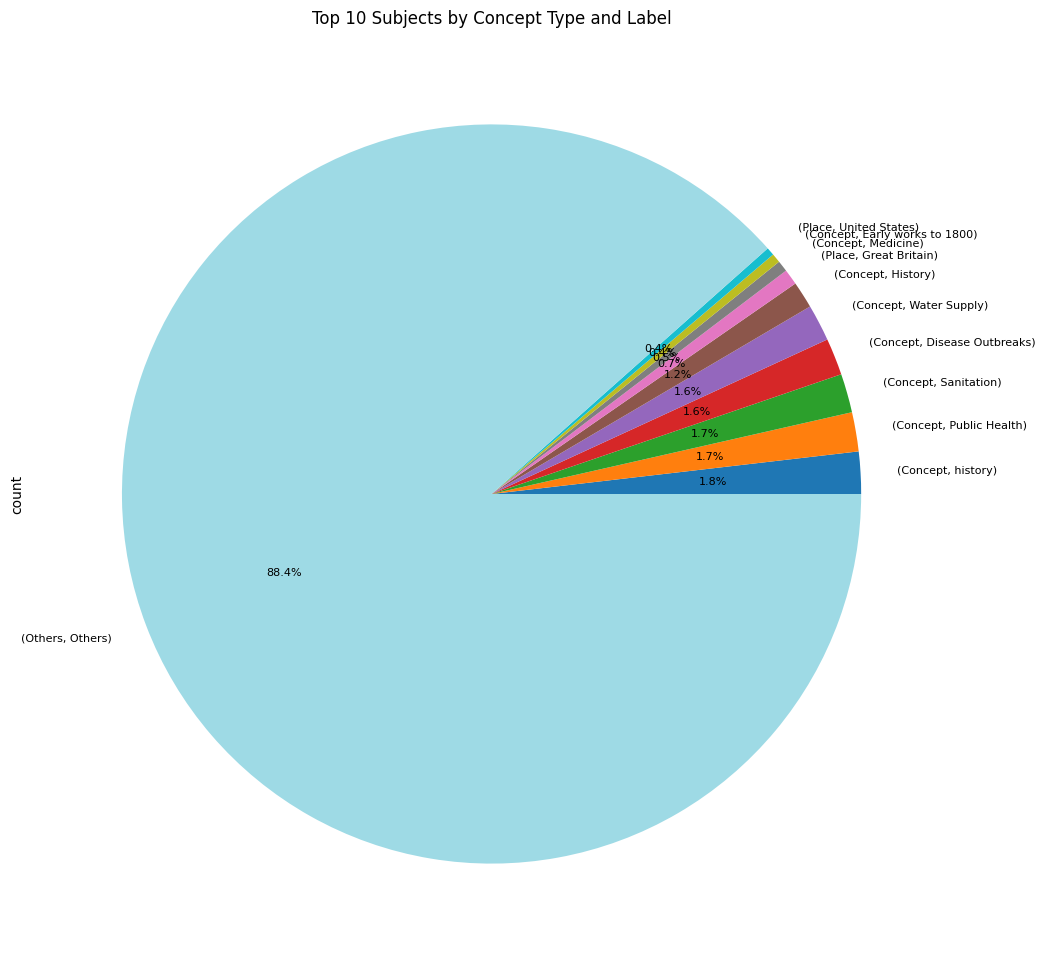

In [29]:

top_n = 10

# Get the "others" count to add to the pie chart using top_concepts

others_count = top_concepts[~top_concepts.index.isin(
    top_concepts.head(top_n).index)]
#Get the count of "Others"
others_count_value = others_count['count'].sum()

# Add "Others" row to the top concepts DataFrame
plot_concepts = top_concepts.head(top_n).copy()
plot_concepts.loc[("Others", "Others"), "count"] = others_count_value
# Plot top subjects by concept type and label
plot_concepts.plot.pie(
    y='count',
    figsize=(12, 12),
    autopct='%1.1f%%',
    legend=False,
    title=f'Top {top_n} Subjects by Concept Type and Label',
    fontsize=8,
    colormap='tab20'
)

### conceptType

<Axes: title={'center': 'Distribution of Subject Concept Type'}, ylabel='count'>

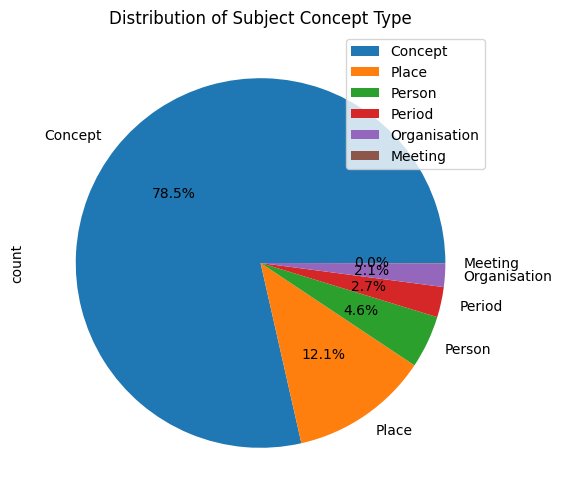

In [45]:
plot_df = subjects_df.groupBy(
    "conceptType").count().orderBy(
        "count",
        ascending=False).toPandas().set_index(["conceptType"])

plot_df.plot(
    kind="pie",
    y="count",
    title="Distribution of Subject Concept Type",
    autopct='%1.1f%%',
    figsize=(10, 6),
)

### ontologyType

<Axes: title={'center': 'Distribution of Subjects by Ontology Type'}, ylabel='count'>

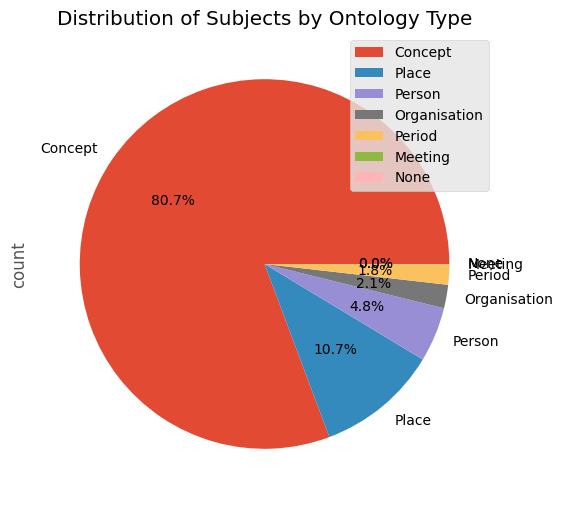

In [28]:
plot_df = subjects_df.groupBy(
    "ontologyType").count().orderBy(
        "count",
        ascending=False).toPandas().set_index("ontologyType")
plot_df.plot(
    kind="pie",
    y="count",
    title="Distribution of Subjects by Ontology Type",
    autopct='%1.1f%%',
    figsize=(10, 6),
)

### identifierTypeId

Count of identifierTypeId 183232


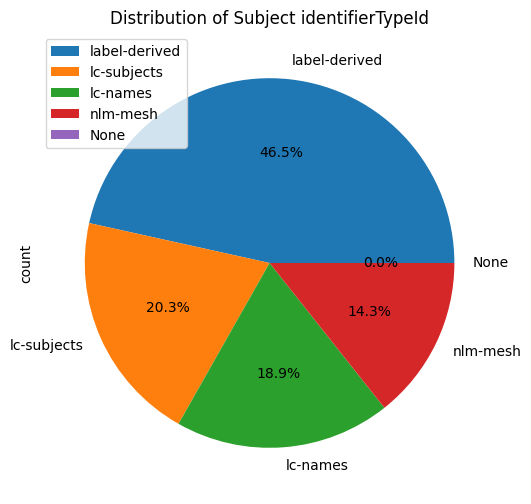

In [63]:
plot_df = subjects_df.dropDuplicates(["canonicalId"]).groupBy(
    "identifierTypeId").count().orderBy(
        "count",
        ascending=False).toPandas().set_index(["identifierTypeId"])

plot_df.plot(
    kind="pie",
    y="count",
    title="Distribution of Subject identifierTypeId",
    autopct='%1.1f%%',
    figsize=(
        10,
        6),
)

print("Count of identifierTypeId",
      plot_df["count"].sum())

### conceptIdSourceIdentifierIdentifierTypeId

Count of conceptIdSourceIdentifierIdentifierTypeId 143658


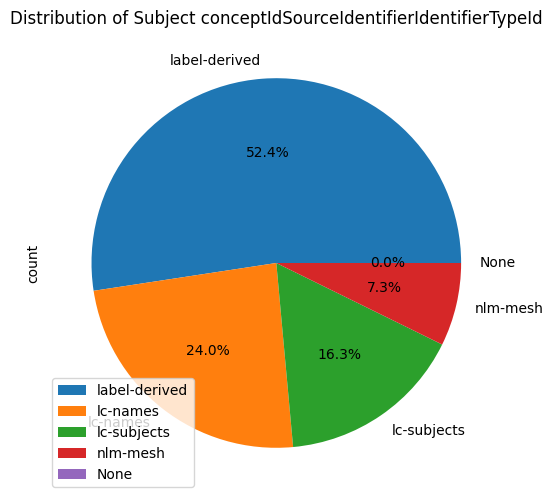

In [62]:
plot_df = subjects_df.dropDuplicates(["conceptIdCanonicalId"]).groupBy(
    "conceptIdSourceIdentifierIdentifierTypeId").count().orderBy(
        "count",
        ascending=False).toPandas().set_index(["conceptIdSourceIdentifierIdentifierTypeId"])

plot_df.plot(
    kind="pie",
    y="count",
    title="Distribution of Subject conceptIdSourceIdentifierIdentifierTypeId",
    autopct='%1.1f%%',
    figsize=(
        10,
        6),
         )
print("Count of conceptIdSourceIdentifierIdentifierTypeId",
      plot_df["count"].sum())

## Contributors

In [58]:
# Select document fields without the top-level "document" field
contributors_df = (
    spark.table("es_works_denormalised")
    .select("document.data.*")
    .select(F.explode("contributors")).select("col.*")
    .select(F.col("id.type").alias("idType"), F.col("roles"), "agent.*")
    .select("*", F.col("id.canonicalId").alias("idCanonicalId"), F.col("id.otherIdentifiers").alias("idOtherIdentifiers"), F.col("id.sourceIdentifier").alias("idSourceIdentifier")).drop("id")
    .select("*",
        F.col("idSourceIdentifier.ontologyType").alias("idSourceIdentifierOntologyType"), 
        F.col("idSourceIdentifier.value").alias("idSourceIdentifierValue"), 
        F.col("idSourceIdentifier.identifierType.id").alias("identifierTypeId")
        ).drop("idSourceIdentifier", "identifierType")
)

contributors_df.show(200, truncate=True)
print("Distinct count", contributors_df.distinct().count())
print("Distinct count without CanonicalId",
      contributors_df.dropDuplicates(["label", "type"]).count())

+--------------+--------------------+--------------------+------------+-------------+------------------+------------------------------+-----------------------+----------------+
|        idType|               roles|               label|        type|idCanonicalId|idOtherIdentifiers|idSourceIdentifierOntologyType|idSourceIdentifierValue|identifierTypeId|
+--------------+--------------------+--------------------+------------+-------------+------------------+------------------------------+-----------------------+----------------+
|Unidentifiable|                  []|Riley, Charles V....|      Person|     egfwgb93|                []|                        Person|              n91097955|        lc-names|
|Unidentifiable|                  []| Manzione, Joseph A.|      Person|     x457nb94|                []|                        Person|     manzione, joseph a|   label-derived|
|Unidentifiable|                  []|University of Mic...|Organisation|     yytj83tc|                []|           

In [61]:
print("Count of idCanonicalId",
      contributors_df.select("idCanonicalId").distinct().count())

Count of idCanonicalId 396198


### identifierTypeId

,identifierTypeId,count
0,lc-names,622347
1,label-derived,521312
2,nlm-mesh,984
3,fihrist,298
4,viaf,281


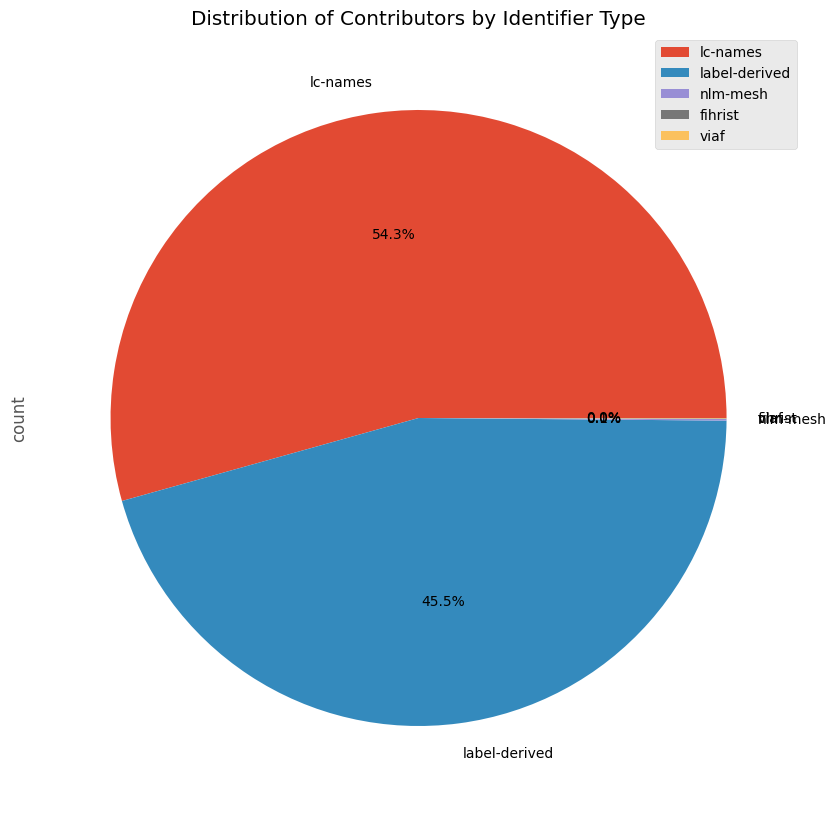

In [21]:
plot_df = contributors_df.groupBy("identifierTypeId").count().orderBy("count", ascending=False).toPandas()
(
    plot_df
    .set_index("identifierTypeId")
    .plot(
        kind="pie",
        y="count",
        title="Distribution of Contributors by Identifier Type",
        autopct='%1.1f%%',
        figsize=(10, 10),
    )
)
plot_df

### type

,type,count
0,Person,807667
1,Organisation,294505
2,Agent,34662
3,Meeting,7002
4,Place,1326
5,Concept,60


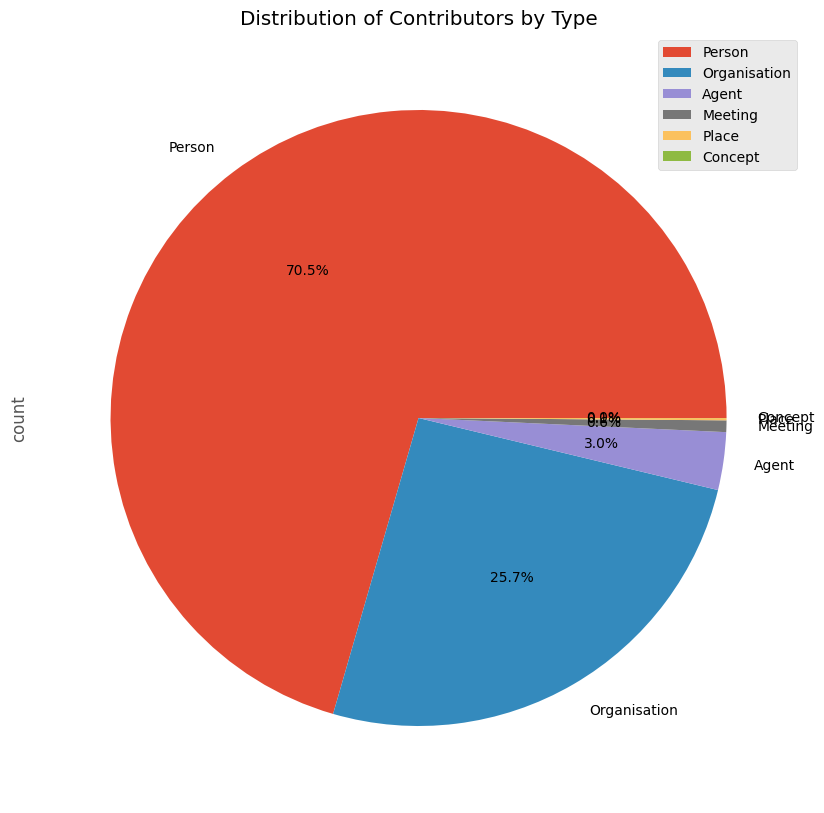

In [23]:
plot_df = contributors_df.groupBy("type").count().orderBy("count", ascending=False).toPandas()
plot_df.set_index("type").plot(
    kind="pie",
    y="count",
    title="Distribution of Contributors by Type",
    autopct='%1.1f%%',
    figsize=(10, 10),
)
plot_df

### Show nlm-mesh

In [67]:
contributors_df.select( "*").where(F.col("identifierTypeId")
                       == "nlm-mesh").show(50, truncate=False)

+--------------+------------+-----------------------------------------------------------------------------------------------------------+------------+-------------+------------------+------------------------------+-----------------------+----------------+
|idType        |roles       |label                                                                                                      |type        |idCanonicalId|idOtherIdentifiers|idSourceIdentifierOntologyType|idSourceIdentifierValue|identifierTypeId|
+--------------+------------+-----------------------------------------------------------------------------------------------------------+------------+-------------+------------------+------------------------------+-----------------------+----------------+
|Unidentifiable|[]          |Lupton, James Irvine. Diseases of cattle, sheep, and pigs.                                                 |Agent       |f8jxmwvp     |[]                |Agent                         |nr2004012894      

### Show lc-names

In [14]:
contributors_df.select( "*").where(F.col("identifierTypeId")
                                   == "lc-names").show(50, truncate=False)

+--------------+--------------------+--------------------------------------------------------------------+------------+-------------+------------------+------------------------------+-----------------------+----------------+
|idType        |roles               |label                                                               |type        |idCanonicalId|idOtherIdentifiers|idSourceIdentifierOntologyType|idSourceIdentifierValue|identifierTypeId|
+--------------+--------------------+--------------------------------------------------------------------+------------+-------------+------------------+------------------------------+-----------------------+----------------+
|Unidentifiable|[]                  |Riley, Charles V. (Charles Valentine), 1843-1895.                   |Person      |egfwgb93     |[]                |Person                        |n91097955              |lc-names        |
|Unidentifiable|[]                  |University of Michigan.                                        